In [1]:
import glob,os
import numpy as np
import pandas as pd
from fitsio import FITS
import re

# import astropy
from astropy.table import Table, setdiff, vstack,join

import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

h = 0.7
file_path = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/"

filepath = r"/bsuscratch/shuleicao/Cardinalv3/"

# Load Halos data with Weak lensing profiles

In [2]:
### Load the halos with the DS and Sigma profiles
sigma_ds_profile =  Table(np.load(filepath+"correctfilev2.npy"))
print(len(sigma_ds_profile))
print(sum(np.all(sigma_ds_profile['Sigma'] == 0, axis=1)))
sigma_ds_profile = sigma_ds_profile[(np.all(sigma_ds_profile['Sigma'] != 0, axis=1)) & (sigma_ds_profile['pid']==-1)]
sigma_ds_profile['Sigma'] = sigma_ds_profile['Sigma']*1e12*h
sigma_ds_profile['DeltaSigma'] = sigma_ds_profile['DeltaSigma']*1e12*h
print(len(sigma_ds_profile))
sigma_ds_profile[:2]

1454571
167514
1208773


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100]
12905996,1104000000000000.0,116.599,18.9969,0.62517,2.1563340659340655,0.464765,-1,0.377642,1129788000000000.0,2.57077,3232607803046852.0 .. 4951584885294.114,221858585992424.06 .. 4427939692031.291,1737067114879232.8 .. 21554116855032.89,-2.0638824814096005e-05 .. 0.6538981002611183,2.6673175421036414e-07 .. 0.0691232562888688,8.064741778139222 .. 1.0457879038100961,287.8731346185066 .. 5.31543402099229
35142654,963800000000000.0,12.3843,15.0544,0.62133,2.0602021978021976,0.673965,-1,0.409137,991244500000000.0,2.46113,1.1785172540359254e+16 .. 8011401459616.633,224823077386162.56 .. 3112729511600.675,2043845776634292.2 .. 21017359969982.85,0.0 .. 0.1991121235725387,0.0 .. 0.06996756822056328,8.109481193785157 .. 1.0461027816248183,287.34227585727774 .. 5.351987610686462


In [3]:
# ## Sigma and DS profile
# sigma_ds_profile =  Table(np.load( file_path + "halos_cardinal_w_lensing_1687.npy"))
# print(len(sigma_ds_profile))
# print(sum(np.any(sigma_ds_profile['DeltaSigma'] != 0, axis=1)))
# print(sum(np.all(sigma_ds_profile['Sigma'] != 0, axis=1)))
# sigma_ds_profile = sigma_ds_profile[np.all(sigma_ds_profile['Sigma'] != 0, axis=1)]
# print(len(sigma_ds_profile))
# sigma_ds_profile[:4]

# Load cluster-halos matched (RedMaPPer)

In [4]:
cluster_halos_red = Table(np.load(file_path + "HaloRun_Halo_Clusters_Lamgt20-20110.npy"))
cluster_halos_red = Table(join(sigma_ds_profile,cluster_halos_red, keys_right=['halo_id','m200'],keys_left=['haloid','Mvir']))
print(len(cluster_halos_red))
cluster_halos_red = cluster_halos_red[(cluster_halos_red['Redshift']>=0.2) & (cluster_halos_red['Redshift']<=0.65)& (cluster_halos_red['lambda']>=20)]
# cluster_halos_red = Table(np.sort(cluster_halos_red_un,order='lambda'))[::-1]
print(len(cluster_halos_red))

cluster_halos_red['lambda_range'] = pd.cut(cluster_halos_red['lambda'], bins=[20, 30, 45, 60, np.inf], labels=['(20,30]', '(30,45]', '(45,60]', '(60,500]'])
cluster_halos_red['z_range'] = pd.cut(cluster_halos_red['Redshift'], bins=[0.2, 0.35, 0.5, 0.65], labels=['(0.2,0.35]', '(0.35,0.5]', '(0.5,0.65]'])

grouped_cl_halos_red = cluster_halos_red.group_by([ 'z_range', 'lambda_range'])

cluster_halos_red[:2]

7820
7463


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta,halo_id,id,m200,ra,dec,z,refmag,refmag_err,mag,mag_err,mem_match_id,lambda,lambda_e,z_lambda,z_lambda_e,cg_spec_z,z_spec_init,z_init,r_lambda,r_mask,scaleval,maskfrac,zred,zred_e,zred_chisq,chisq,z_lambda_niter,ebv_mean,lnlamlike,lncglike,lnlike,ra_orig,dec_orig,w,dlambda_dz,dlambda_dz2,dlambdavar_dz,dlambdavar_dz2,z_lambda_raw,z_lambda_e_raw,bkg_local,lim_exptime,lim_limmag,lim_limmag_hard,lambda_c,lambda_ce,ncent_good,maskgal_index,pzbins,pz,ra_cent,dec_cent,id_cent,lambda_cent,zlambda_cent,p_cen,q_cen,p_fg,q_miss,p_sat,p_c,lambda_range,z_range
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100],int64,int64,float32,float64,float64,float32,float32,float32,float32[4],float32[4],int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32[21],float32[21],float64[5],float64[5],int64[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32[5],float32[5],object,object
2583063,267400000000000.0,169.382,47.2833,0.310835,1.58106463878327,0.449461,-1,0.309073,277851100000000.0,1.61068,2919820191159664.0 .. 1043603577247.4805,-35341680995029.555 .. 1424473936615.3147,566642022349000.6 .. 6189112527700.987,2.970600369931629e-05 .. 0.7959358266897882,5.827664495263838e-07 .. 0.1665607820021916,8.14784788815788 .. 1.0,131.94855597616763 .. 0.0,2583063,87001073651,267400000000000.0,306.3130376896028,-45.68660434964616,0.31037349,16.965763,0.0054757674,19.369974 .. 16.965763,0.00831528 .. 0.0054757674,4225,26.761438,2.1556258,0.30325016,0.008422698,0.31037349,0.0,0.0,0.7682488,1.1523732,1.0118104,0.009429622,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0629818,1861.0948,-25.25452,776.4697,0.0,0.0,0.0,0.27865246,22.47364,23.33665,0.0,0.0,0,59,0.25470987 .. 0.35179046,1.8740894e-06 .. 5.453747e-06,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,"(20,30]","(0.2,0.35]"
2865388,343800000000000.0,158.824,43.2032,0.292247,1.7386651958080528,0.645331,-1,0.435861,359562100000000.0,1.75518,3367498572924773.0 .. 1717217159636.3926,86474987775013.28 .. 346314032288.11646,676074841198952.1 .. 12235325734604.41,-1.3404642168463923e-06 .. 0.07187618241787581,1.0009043415434238e-07 .. 0.08463139272147693,9.41972930181457 .. 1.0,147.95119272417446 .. 0.0,2865388,92000885484,343800000000000.0,315.6922106017438,-40.670825231321004,0.29410264,16.824503,0.0048866537,18.967258 .. 16.824503,0.0061681 .. 0.0048866537,1941,26.990263,3.1322796,0.28994408,0.008686038,0.29410264,0.0,0.0,0.76955813,1.1543372,1.0747478,0.06979927,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0722835,-1464.4607,-40.15961,9412.771,0.0,0.0,0.0,0.2816006,22.485304,23.33665,0.0,0.0,0,24,0.23959486 .. 0.3402933,5.009185e-07 .. 4.7464146e-06,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,"(20,30]","(0.2,0.35]"


## Load the error data (DS and S)

In [5]:
ds_std_err = Table(np.load(file_path+"DS-Errorbars.npy"))
print(len(ds_std_err))
s_std_err = Table(np.load(file_path+"Sigma-Errorbars.npy"))
print(len(s_std_err))

s_sem_err = Table(np.load(file_path+"Sigma-Errorbars_SEM.npy"))
print(len(s_sem_err))
ds_sem_err = Table(np.load(file_path+"DS-Errorbars_SEM.npy"))
print(len(ds_sem_err))
s_sem_err[:2]

12
12
12
12


z_range,lambda_range,mean,sem
bytes10,bytes10,float64[15],float64[15]
"(0.2,0.35]","(20,30]",588678221295588.0 .. 9890037042635.127,14331240772573.498 .. 157407939883.33237
"(0.2,0.35]","(30,45]",792238247852328.1 .. 10379468010583.676,33688946586700.555 .. 312109574876.7687


In [6]:
Rmin = 0.5
Rmax = 50
pimax = 100
n_decade = (np.log10(Rmax)-np.log10(Rmin))
nrp_per_decade = 10
n_rp = int(nrp_per_decade*n_decade + 1 + 0.001) ## adding the inner most bin
lnrp = np.linspace(np.log(Rmin), np.log(Rmax), 15) # n_rp
bins = np.exp(lnrp)  #*0.70

In [7]:
## Weighted Profile
def stacked_profile_weighted_by_mass_redshift(lnM_select, z_select, prof_select, lnM_all, z_all, profile_A, dm=0.1, dz=0.05):
    #### set up the bins for mass and redshift  (sigma_select/profile_select, sigma_all/profile_all)
    min_m = min(lnM_select)#-dm
    max_m = max(lnM_select)#+dm
    min_z = min(z_select)#-dz
    max_z = max(z_select)#+dz

    # print('z', min_z, max_z)
    m_bins = np.arange(min_m, max_m+dm, dm)
    z_bins = np.arange(min_z, max_z+dz, dz)
    nM = len(m_bins)-1
    nz = len(z_bins)-1
    # print('nM, nz', nM, nz)

    profile_select = np.array([i.tolist() for i in prof_select])
    profile_all = np.array([i.tolist() for i in profile_A])

    nr = np.shape(profile_select)[1]#rbp.nbins_phys_mpc...1
    profile_weighted = np.zeros(nr)
    weight_norm = 0


    pdf1_list = np.zeros([nz, nM]) # see how many bins are too narrow
    pdf2_list = np.zeros([nz, nM]) # see how many bins are too narrow

    for iz in range(nz):
        z_lo = z_bins[iz]
        z_hi = z_bins[iz+1]
        # print(z_lo,z_hi)
        for iM in range(nM):
            m_lo = m_bins[iM]
            m_hi = m_bins[iM+1]
            # print(m_lo, m_hi)
            
            select_bin = (lnM_select >= m_lo)&(lnM_select < m_hi)&(z_select>=z_lo)&(z_select<z_hi)
            weight = len(lnM_select[select_bin]) * 1.
            # print(weight, len(lnM_select[select_bin]),lnM_select[select_bin])
            weight_norm += weight
            # print(weight_norm)
            select_all = (lnM_all >= m_lo)&(lnM_all < m_hi)&(z_all>=z_lo)&(z_all<z_hi)

            pdf1_list[iz, iM] = weight
            # print(pdf1_list)
            pdf2_list[iz, iM] = len(lnM_all[select_all])
            # print(pdf2_list)

            if weight > 0 and len(lnM_all[select_all]) > 0:
                # print(weight, len(lnM_all[select_all]))
                # if weight == len(lnM_all[select_all]):
                    # print('bin is too narrow!')
                profile_weighted += (np.mean(profile_all[select_all, :], axis=0)*weight) #0
                #profile_weighted += np.nan_to_num(np.mean(profile_all[select_all, :], axis=0)*weight)
            #profile_weighted = np.nan_to_num(profile_weighted)
    profile_weighted /= weight_norm
    
    pdf1_list = np.concatenate(pdf1_list)
    pdf2_list = np.concatenate(pdf2_list)
    diff_list = pdf2_list - pdf1_list
    # print('pdf1==pdf2', len(diff_list[diff_list == 0]), 'out of', len(diff_list))

    return profile_weighted

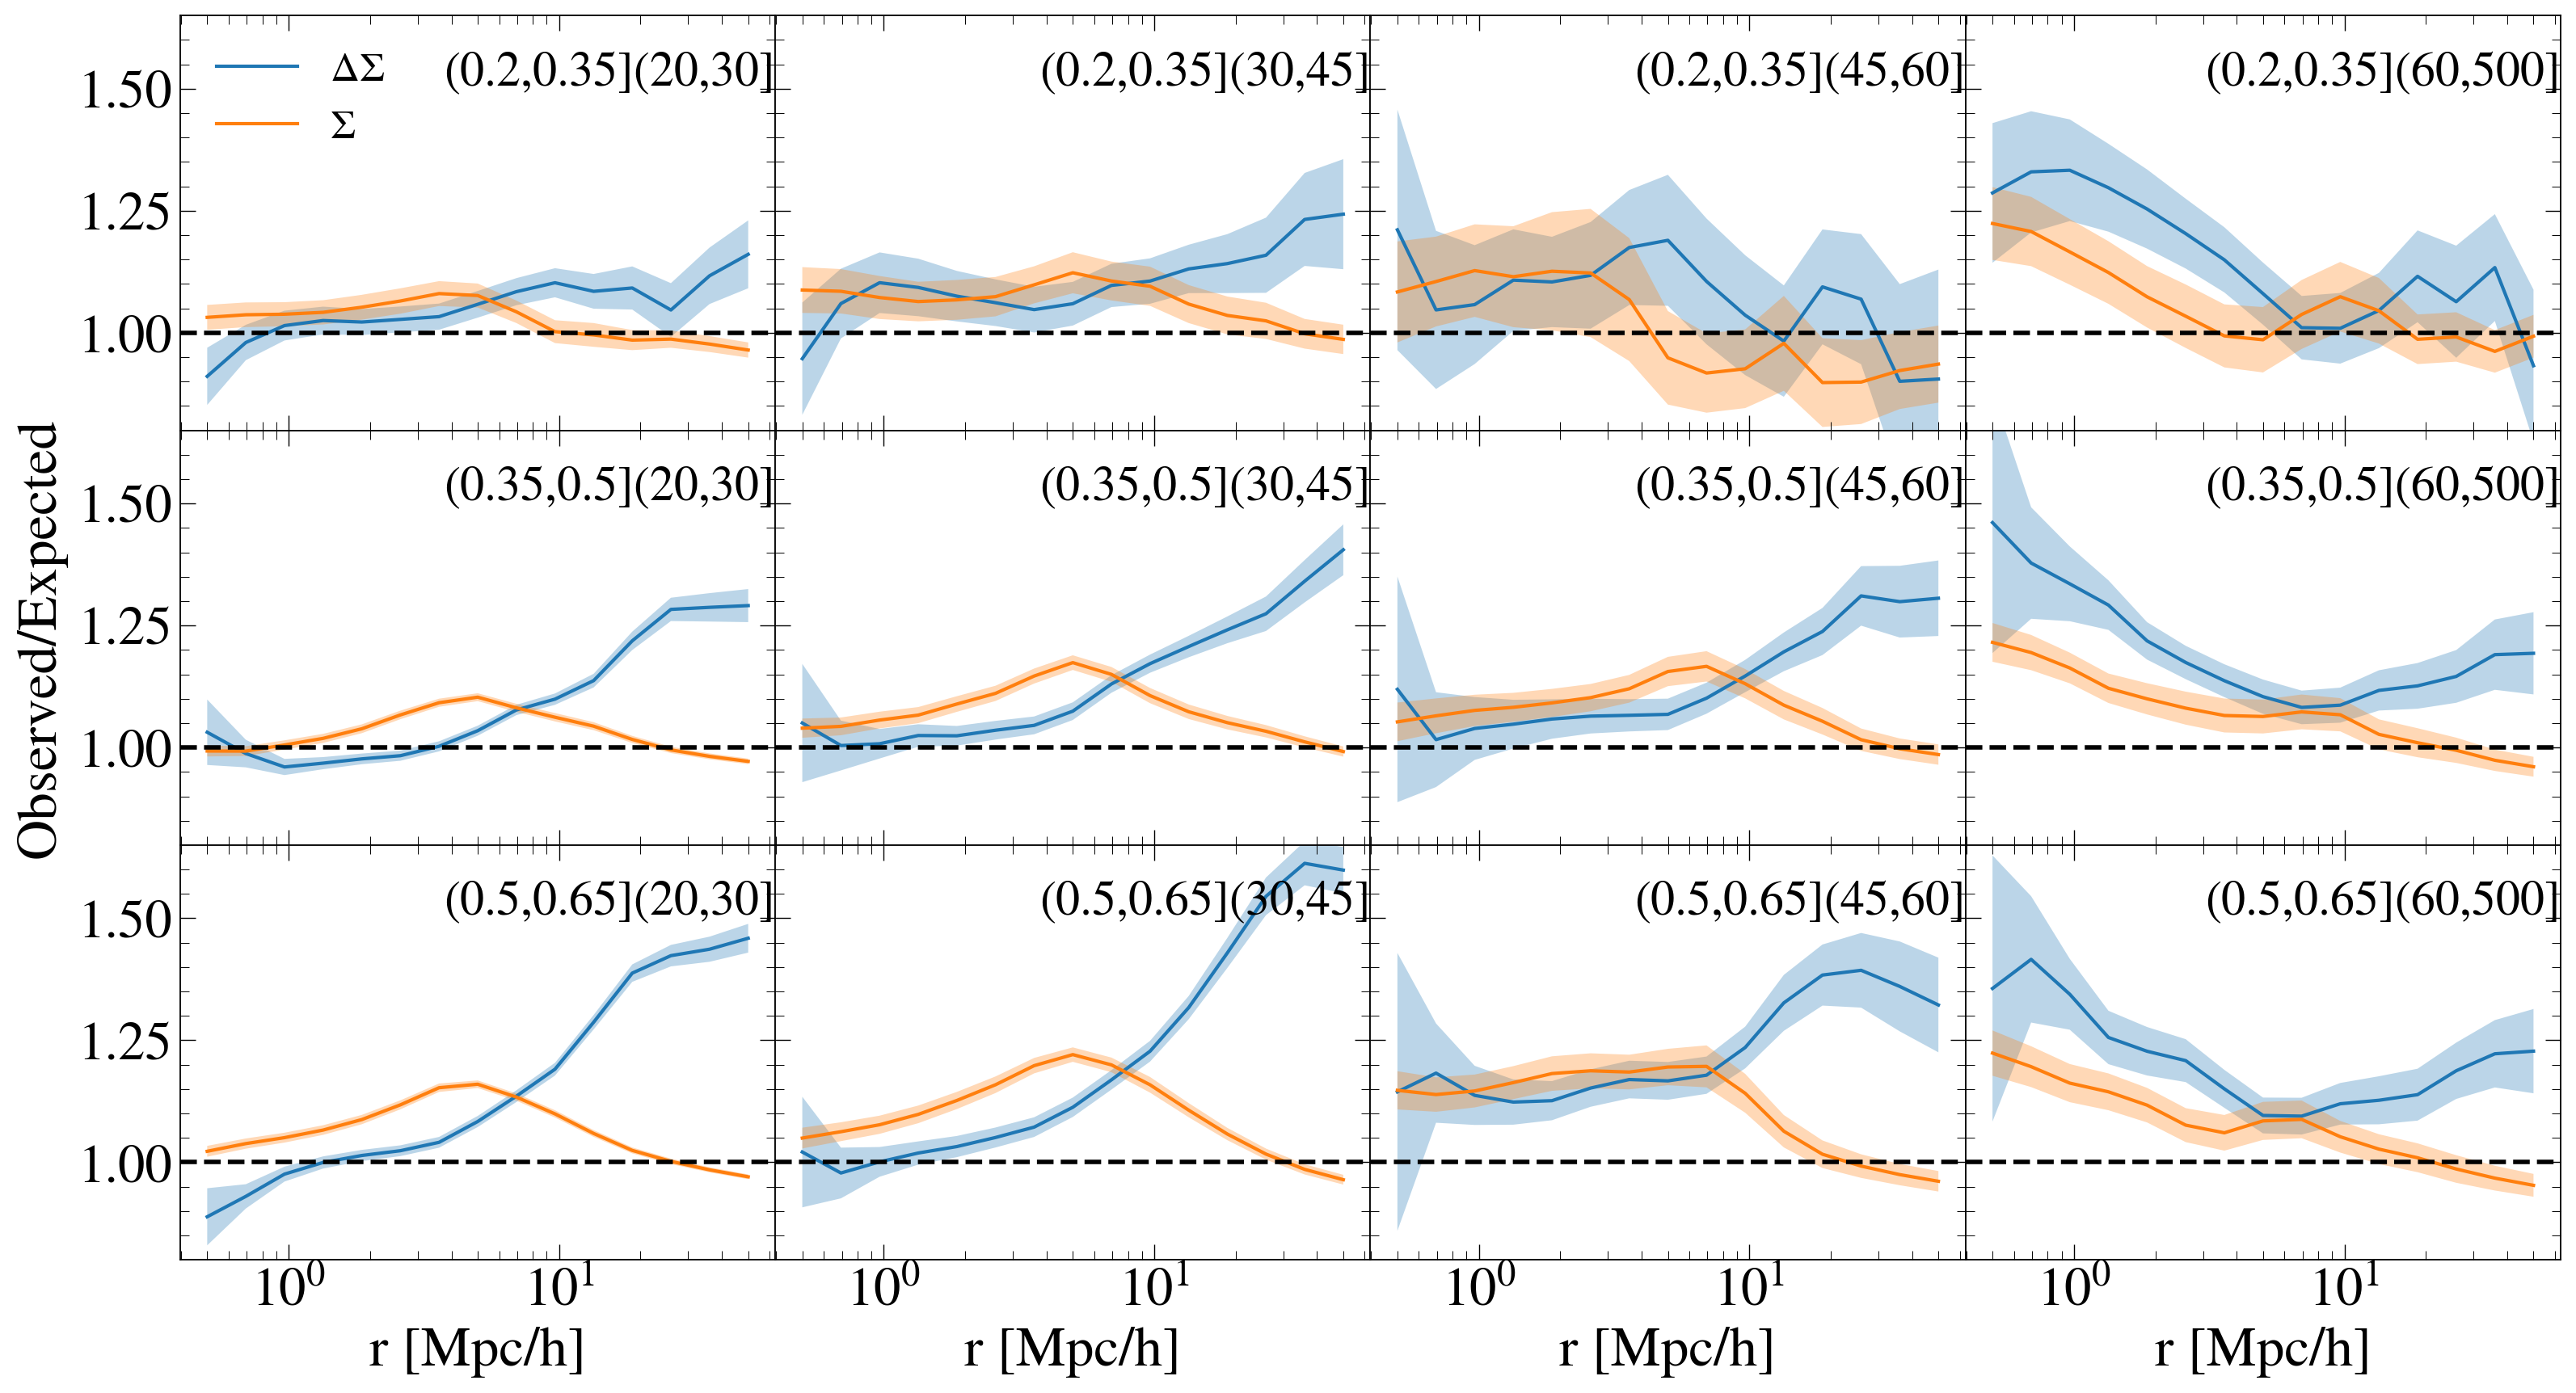

In [12]:
from matplotlib.ticker import MaxNLocator

# Create a figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(19, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax in axes:   
    ax.tick_params(axis='both', which='major', labelsize=24)

for i, lambda_group in enumerate(grouped_cl_halos_red.groups):
    lnM_sel_red = np.log10(lambda_group['Mvir'])
    z_sel_red = lambda_group['Redshift']
    profile_sel_red = lambda_group['Sigma']
    profile_sel_ds_red = lambda_group['DeltaSigma']
    
    # Extracting the z_range from lambda_group
    z_range = lambda_group['z_range'][0]
    lambda_range = lambda_group['lambda_range'][0]
    z_min, z_max = map(float, z_range.strip('()[]').split(','))

    underlying_halos = sigma_ds_profile[(sigma_ds_profile['Redshift'] >= z_min) & (sigma_ds_profile['Redshift'] < z_max)]
    lnM_All = np.log10(underlying_halos['Mvir'])
    z_All = underlying_halos['Redshift']
    profile_All = underlying_halos['Sigma']
    profile_All_ds = underlying_halos['DeltaSigma']
    
    expected_ds_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_ds_red, lnM_All, z_All, profile_All_ds)
    expected_sigma_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_red, lnM_All, z_All, profile_All)

    ratio_ds_red = np.array(profile_sel_ds_red.mean(axis=0)) / np.array(expected_ds_red)
    ratio_sigma_red = np.array(profile_sel_red.mean(axis=0)) / np.array(expected_sigma_red)
    
#     ### Error
#     err_sel_signal = ds_err['std_deltasigma'][(ds_err['lambda_range']==lambda_range) & (ds_err['z_range']==z_range)]
    err_ds_red = ds_sem_err['sem'][(ds_sem_err['lambda_range']==lambda_range) & (ds_sem_err['z_range']==z_range)] / np.array(expected_ds_red)
    #error_propagation_ratio(ratio_ds_red,profile_sel_ds_red.mean(axis=0),err_sel_signal)
    #ds_err['std_deltasigma'][(ds_err['lambda_range']==lambda_range) & (ds_err['z_range']==z_range)] / np.array(expected_ds_red)
    err_sigma_red = s_sem_err['sem'][(s_sem_err['lambda_range']==lambda_range) & (s_sem_err['z_range']==z_range)] / np.array(expected_sigma_red)

    axes[i].plot(bins, ratio_ds_red, label='$\Delta\Sigma$')
    axes[i].fill_between(bins, ratio_ds_red-err_ds_red[0], ratio_ds_red+err_ds_red[0], alpha=0.3)
    
    axes[i].plot(bins, ratio_sigma_red, label='$\Sigma$')
    axes[i].fill_between(bins, ratio_sigma_red-err_sigma_red[0], ratio_sigma_red+err_sigma_red[0], alpha=0.3) 

    axes[i].axhline(y=1, color='black', linestyle='--', linewidth=2)
    
    axes[i].set_title(f'{z_range}{lambda_range}', y=0.8, loc='right')
    axes[i].set_xlabel('r [Mpc/h]', fontsize=25)
    axes[i].set_xscale('log')
    axes[i].set_ylim(0.8,1.65)
        
    axes[i].grid(visible=False)
    axes[0].legend(loc='upper left',frameon=False)
    
    if i % 4 >= 1:
        axes[i].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='upper'))
    
axes[0].set_ylabel('Observed/Expected', fontsize=25)
axes[0].yaxis.set_label_coords(-0.19, -0.5)

plt.subplots_adjust(hspace=0, wspace=0)
filep = r'/bsuhome/gladyskamau/BSU-Research/Cardinal/'
plt.savefig(filep + 'Images/cardinal_sel_bias.png', facecolor='white')
plt.show()